In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.default_rng()



SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rc('axes', labelweight='bold')

## Intro

This notebook will walk through a breif introduction to Gaussian Process Regression. In a sentnce, GPR works by fitting a multivariate gaussian distribution to a set of training data, then uses that distrubution to make predictions on new data. Of course its far more complicated than this, as this tutorial will introduce. GPR is an attractive machine learning method because it does well with small data sets. Due to the gaussian nature of the method, it also provides estimates of uncertainty about its predictions, which can be useful. For more information, refer to the PDF available free online: C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006, ISBN 026218253X. Available at www.GaussianProcess.org.

## 1. Define Some Test Data

The first step is to define some data to work with. Here we will learn a sine function, although any 1D function should work with this code.

In [71]:
x = np.linspace(0, 6*np.pi, 1000).reshape(1000,1)
y = np.sin(x)#+np.random.rand(1000,1)

# randomly sample 20 points from q, y:

#xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42)
ntrain=10

train_ind = np.zeros(ntrain)
for i in range(0,ntrain):
    train_ind[i] = int(np.random.randint(0, 1000))

train_ind = np.sort(train_ind.astype(int))

xtrain = x[train_ind]
ytrain = y[train_ind]

## 2. Define a Covariance function

The next step is to define a covariance function. The covariance function specifies the covariance between pairs of random variables. The covariance function itself, as defined here, computes the covariacnce between two samples, x1 and x2. Note that these sample observations can be multi-dimensional - the covariance function computes the euclidean norm between them.

In [72]:
## Define Covariance Function:

def SE(x1, x2):
    se = np.exp(-0.5*(np.abs(np.linalg.norm(x1 - x2)))**2)
    return se


Once we have a covariance function, the next step is to calculate a covariance matrix for our input data. In GPR, we will want to calculate two covariance matrices: one between our training observation features and themselves, and one between the training features and the testing features. This is done in the getCov function. Here, for each element of the covariance matrix, the covariance between the features of the i'th and j'th observation is computed. This does give us a positive definite matrix for the auto-covariance of the training features, which makes our life easier later when we need to invert the covariance matrix. Note that we add a small epsilon onto the diagonal of the covariance matrix here - this helps keep the eigenvalues from disappearing, which keeps the Cholesky decomposition we use later happy. 

In [73]:
# Generate covariance matrix:

def getCov(func, x1, x2):
    K = np.zeros((len(x1), len(x2)))
    
    for i in range(0, len(x1)):
        for j in range(0, len(x2)):
            Knew = SE(x1[i], x2[j])
            #if np.abs(np.real(Knew))<1e-15:
            #    print(Knew)
            #    Knew = 0
            K[i,j] = Knew
    K = K + np.eye(len(x1), M=len(x2))*1e-10
    
    return K

## 3. Draw samples from our Prior Distribution

Once we have some data and a covariance matrix for it, we can draw samples from a gaussian distribution and plot them. We do this using the method described in \cite{the GPR book}. The sampleGaussian function takes in a vector of observation features, the mean of the target value distribution at each observation point, and the covariance matrix for the input features with themselves, and returns a vector of sampled y values to go with the feature x's.

In [74]:
def sampleGaussian(xinput, mean, cov):
    """
    Samples one function from the prior distribution given space x1 and covariance function covfunc
    """
    I = np.eye(len(xinput))
    
    K = cov
    K= K+1e-10*I
    L = np.linalg.cholesky(K)
    mean = mean.reshape(len(mean))
    U = rng.multivariate_normal(mean, I)
    x_samp = mean+np.matmul(L, U.T)
    
    return x_samp

Text(0.5, 1.0, 'Four randomly sampled prior functions')

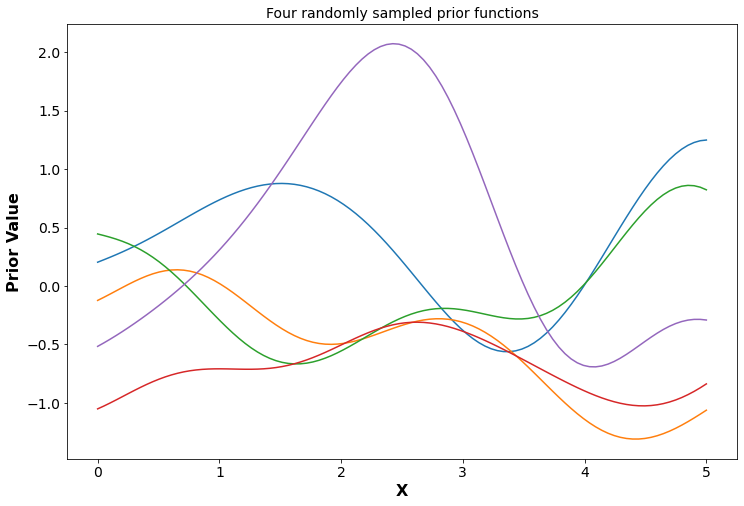

In [87]:
# sample from prior:

x1 = np.linspace(0,5,100)

plt.figure(figsize=(12,8))

for i in range(0, 5):
    m = np.zeros(len(x1))
    K = getCov(SE, x1, x1)
    xsamp = sampleGaussian(x1, m, K)
    plt.plot(x1, xsamp)
    
plt.xlabel('X')
plt.ylabel('Prior Value')
plt.title('Four randomly sampled prior functions')

## 3. "Train" our GPR model

Train is in quotes because the distinction between training a GPR and predicting with one still is not clear to me. Because the covariance between input observations is so central to GPR's, we need to calculate the covariance between the training data and the testing inputs, then multiply this covariance with a solved-for-in-training alpha vector. For the code here, I have split the training alpha and making a prediction steps up into two functions.

In [88]:
def GPRTrain(xtrain, ytrain, cov):

    K = getCov(cov, xtrain, xtrain)
    L = np.linalg.cholesky(K)
    alphaprime = np.linalg.solve(L, ytrain)
    alpha = np.linalg.solve(L.T, alphaprime)

    return alpha, L

In [89]:
alpha, L = GPRTrain(xtrain, ytrain, SE)

## 4. Make Predictions with our Model

To make predictions with our model, we take the alpha and lower triangular Cholesky matrix we got out of the GPRTrain function, and feed them to the GPRPredict function along with our test features values, the training feature values (so that the covariance can be calculated), and the covariance function we would like to use. This function will calculate the mean predicted value for each test data point, as well as the covariance of these predictions. We can then plot the predicted y values, along with the true y values. The shading in the plot represents 2 standard deviations from the prediction. This plot shows that the model has high confidence/a small standard deviation where we have training data, but that the width of the confidence interval gets much larger where we do not have training data.

In [90]:
def GPRPredict(xtest, xtrain, alpha, cov, L):
    
    Kstartrain = getCov(SE, xtrain, xtest)
    Kstar = getCov(SE, xtest, xtest)
    #this is just a dot product:
    ymean = np.matmul(Kstartrain.T, alpha)

    v = np.linalg.solve(L, Kstartrain)

    covariance = Kstar-np.matmul(v.T, v)
    
    return ymean, covariance

In [91]:
ypred, covariance = GPRPredict(x, xtrain, alpha, SE, L)

Text(0.5, 1.0, 'GPR Predictions of a Sine Function, 10 Training Points')

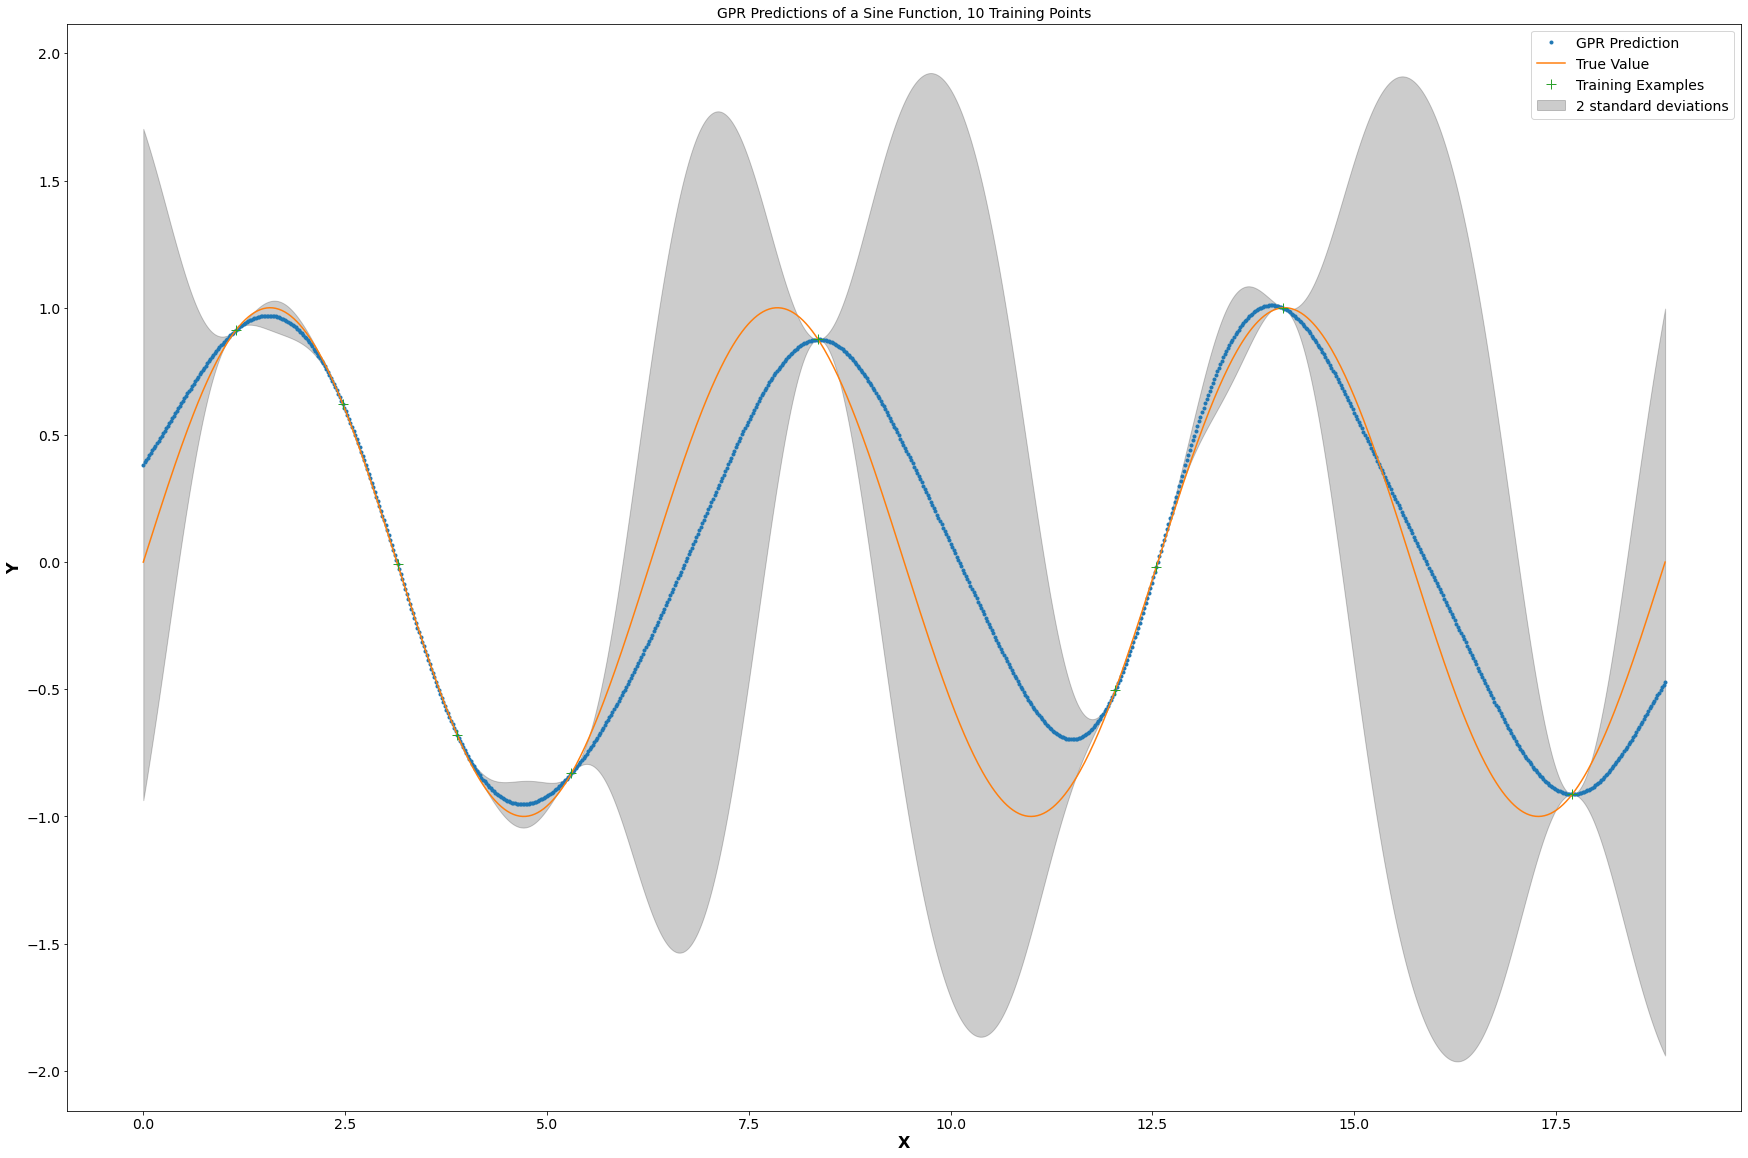

In [92]:
stdev = np.array([covariance[i,i] for i in range(0,len(covariance))])
plt.figure(figsize=(30,20))
plt.plot(x, ypred, '.', label = 'GPR Prediction')
plt.plot(x, y, label = 'True Value')
plt.plot(xtrain, ytrain, '+', markersize=10, label = 'Training Examples')
plt.fill_between(x[:,0], ypred[:,0]-2*stdev, ypred[:,0]+2*stdev, alpha=0.2, color='k', label = '2 standard deviations')
plt.legend()
plt.ylabel('Y')
plt.xlabel('X')
plt.title('GPR Predictions of a Sine Function, {} Training Points'.format(ntrain))